In [ ]:
import os
import time
import pickle
import shutil
from pathlib import Path
import json

import random as rnd
from random import randint
from random import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import PIL
from PIL import Image
import cv2

import keras
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation
from keras import backend as K
from keras.applications.vgg16 import VGG16 
from keras.models import Model

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

In [19]:
import scipy

In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8230511595779078811
]


In [21]:
# if None is set, we take whole dataset
image_count_taken_from_dataset = 100
# < 1 => percent from dataset, > 1 = count
validation_set_size = 3

# training model 
epochs = 300
batch_size = 2

# predict images by model?
restore_datasets_train = True
restore_datasets_validation = True
restore_limit = 10 # limiter on how many imgs to restore

# clustering
cluster_count = [3,7] # [start, end] or int or None
clustering_method = 'gm' # 'kmeans' 'gm'(full) 'gm_diag' 'gm_spherical' 

# image size
image_processing_size = 224

In [22]:
# helper functions

def safe_mkdir(path):
    Path(path).mkdir(parents=True, exist_ok=True)

def safe_mkdir_clean(path):
    safe_mkdir(path)
    shutil.rmtree(path)
    safe_mkdir(path) 

In [23]:
# laod all frames
original_rims_path = './3_extracted_rims/'
original_rims_files = [f for f in os.listdir(original_rims_path) if os.path.isfile(os.path.join(original_rims_path, f))]
paths = []

for f in original_rims_files:
    path = os.path.join(original_rims_path, f)
    paths.append(path)

In [24]:
# preprocess paths - shuffle, limit number
# train/validation sizes counted
shuffle(paths)
if image_count_taken_from_dataset is None:
    image_count_taken_from_dataset = len(paths)
else:
    paths = paths[:image_count_taken_from_dataset]

if validation_set_size < 1:
    validation_set_size = int(image_count_taken_from_dataset * validation_set_size)

train_set_size = image_count_taken_from_dataset - validation_set_size

print(f"Dataset size: {image_count_taken_from_dataset}")
print(f"Train set size: {train_set_size}")
print(f"Validation set size: {validation_set_size}")

Dataset size: 100
Train set size: 97
Validation set size: 3


In [25]:
# prepare images
imgs = []

for p in paths:
    img = cv2.imread(p) 
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_resized = cv2.resize(img_gray, (image_processing_size, image_processing_size))
    img_numpy = np.array(img_resized) / 255
    imgs.append(img_numpy)

In [26]:
# Build the autoencoder
model = Sequential()

model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu', input_shape=(image_processing_size, image_processing_size,1)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.02))

# 112x112

model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.02))

# 56x56

model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.02))

# 28x28

model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.02))

# 14 x 14

model.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.02))

# 7x7
# botleneck! 
model.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
# botleneck! 
# 7x7

model.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.02))

# 14x14

model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.02))

# 28x28

model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.02))

# 56x56

model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.02))

# 112x112

model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.02))

# 224x224

model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.001))

model.compile(optimizer='adam', loss="mse")

In [27]:
imgs_train = imgs[:train_set_size]
imgs_val = imgs[train_set_size:]
paths_train = paths[:train_set_size]
paths_val = imgs[train_set_size:]

imgs_train = np.array(imgs_train)
imgs_val = np.array(imgs_val)
imgs_train = np.expand_dims(imgs_train, axis=3)
imgs_val = np.expand_dims(imgs_val, axis=3)
print(imgs_train.shape)
print(imgs_val.shape)

(97, 224, 224, 1)
(3, 224, 224, 1)


In [28]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2564982271159441583
]


In [29]:
# Train the model
model.fit(imgs_train, imgs_train, epochs=epochs, batch_size=batch_size, validation_data=(imgs_val, imgs_val), verbose=1)

Epoch 1/300
 6/49 [==>...........................] - ETA: 54s - loss: 0.1392

KeyboardInterrupt: 

In [68]:
# Restoring testing dataset
if restore_datasets_train:
    restored_training_dataset = imgs_train
    if restore_limit is not None:
        restored_training_dataset = restored_training_dataset[:restore_limit]
    restored_training_dataset = model.predict(restored_training_dataset)
    restored_training_dataset = restored_training_dataset.reshape((-1,image_processing_size,image_processing_size))
    print("Restored training dataset shape: " + str(restored_training_dataset.shape))

# Restoring validation dataset
if restore_datasets_validation:
    restored_validation_dataset = imgs_val
    if restore_limit is not None:
        restored_validation_dataset = restored_validation_dataset[:restore_limit]
    restored_validation_dataset = model.predict(restored_validation_dataset)
    restored_validation_dataset = restored_validation_dataset.reshape((-1,image_processing_size,image_processing_size))
    print("Restored validation dataset shape: " + str(restored_validation_dataset.shape))

Restored training dataset shape: (10, 224, 224)
Restored validation dataset shape: (8, 224, 224)


In [69]:
# Save restored images from previous step 
def save_restored_images(restored_images, original_images, folder):
    safe_mkdir_clean(folder)
    for i in range(len(restored_images)):
        new_path = os.path.join(folder, f"after_{i}.png")
        res1 = restored_images[i].reshape((image_processing_size,image_processing_size))
        image = Image.fromarray(np.uint8(res1 * 255) , 'L')
        image.save(new_path)

        new_path = os.path.join(folder, f"before_{i}.png")
        res = original_images[i].reshape((image_processing_size,image_processing_size))
        image = Image.fromarray(np.uint8(res * 255) , 'L')
        image.save(new_path)

save_restored_images(restored_training_dataset, imgs_train, "./train_reconstructed/")
save_restored_images(restored_validation_dataset, imgs_val, "./val_reconstructed/")

In [70]:
# Extract the encoder
encoder = K.function([model.layers[0].input], [model.layers[10].output])

In [71]:
# Encode the training set
encoded_images = encoder([imgs_train[:]])[0].reshape(-1,10*7*7)
encoded_images.shape

(42, 490)

[t-SNE] Computing 41 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.001s...
[t-SNE] Computed neighbors for 42 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 0.886329
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.705322
No handles with labels found to put in legend.
[t-SNE] KL divergence after 1000 iterations: 0.293677
(42, 2)


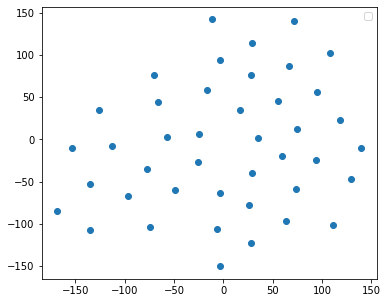

In [72]:
# TSNE
tsne_em = TSNE(n_components=2, verbose=1).fit_transform(encoded_images)

inp = tsne_em
print(inp.shape)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
plt.scatter(inp[:,0], inp[:,1])
plt.legend()
plt.show()

In [73]:
def cluster_data(number_of_clusters, data):
    clustered_labels = None
    if clustering_method == 'gm':
        gm = GaussianMixture(n_components=number_of_clusters).fit(clustered_data)
        clustered_labels = gm.predict(data)
    elif clustering_method == 'gm_diag':
        gm = GaussianMixture(n_components=number_of_clusters, covariance_type='diag').fit(clustered_data)
        clustered_labels = gm.predict(data)
    elif clustering_method == 'gm_spherical':
        gm = GaussianMixture(n_components=number_of_clusters, covariance_type='spherical').fit(clustered_data)
        clustered_labels = gm.predict(data)
    elif clustering_method == 'kmeans':
        kmeans = KMeans(n_clusters=number_of_clusters)
        clustered_labels = kmeans.fit_predict(data)
    return clustered_labels

def write_clustered_data_to_file(labels, number_of_clusters):
    # create basic folders
    rims_clusters_folder = "./rims_clusters/"
    safe_mkdir(rims_clusters_folder)

    # create folder for this number of clusters
    safe_mkdir_clean(f"{rims_clusters_folder}{str(number_of_clusters)}_clusters/")

    # create folder for every cluster
    clustered_labels_uniq = list(set(labels))
    for label in clustered_labels_uniq:
        safe_mkdir(os.path.join(rims_clusters_folder, f"{str(number_of_clusters)}_clusters/", f"cluster_{label}"))

    # saving
    coutner = 0
    for label in labels:
        original_path = paths[coutner]  
        new_path = os.path.join(f"{rims_clusters_folder}{str(i)}_clusters/cluster_{str(label)}/", original_path.split('/')[-1])
        shutil.copy(original_path, new_path)
        coutner = coutner + 1

In [74]:
rims_clusters_folder = "./rims_clusters/"
safe_mkdir_clean(rims_clusters_folder)

clustered_data = encoded_images

if cluster_count is None:
    pass
elif isinstance(cluster_count, list):
    for i in range(cluster_count[0], cluster_count[1] + 1):
        labels = cluster_data(i, clustered_data)
        write_clustered_data_to_file(labels, i)
elif isinstance(cluster_count, int):
    labels = cluster_data(cluster_count, clustered_data)
    write_clustered_data_to_file(labels, cluster_count)